In [2]:
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=False, theme='ggplot')
%run -m ipy_startup
%matplotlib inline
from research.wmi import data, transforms
import plotly.plotly as py
import plotly.graph_objs as go

# Water Quality (Over Time)

In [2]:
# Get water quality measurements over time
d, idx_proj, idx_qual = data.get_project_view_03()

Loading table "AssessmentSummaryInformation"
Loading table "Countries"
Loading table "ProjectsInformation"
Loading table "SafeWaterProjectMonthlySummary"
Loading table "WaterQualityTests"
Loading table "WaterQualityTestParameters"
Loading table "DistributionPoints"


In [4]:
d['WaterSourceType'].value_counts()

Drilled borehole         239
Other                    167
Drilled Borehole         112
Spring                    99
River                     89
Drilled Well/Borehole     83
Hand-dug well             65
Hand-Dug Well             58
Lake                      29
Name: WaterSourceType, dtype: int64

In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637 entries, 0 to 2636
Data columns (total 52 columns):
AnalysisDateAndTime            2637 non-null datetime64[ns]
ApplicableReport               2637 non-null object
AssessmentID                   2637 non-null int64
AssessmentName                 2637 non-null object
CommissioningDate              2095 non-null datetime64[ns]
Continent                      2637 non-null object
Country                        2637 non-null object
CountryCode2                   2637 non-null object
DistributionPointID            2637 non-null int64
DistributionPointName          2637 non-null object
Feasible                       2637 non-null object
FollowUpReportDate             1483 non-null object
GPSLatitude                    2489 non-null object
GPSLongitude                   2489 non-null object
InstallationDate               1846 non-null datetime64[ns]
LabTechnicianName              2637 non-null object
OperatorCompensationMethod     2583 non

## Distribution of Measurement Counts

In [19]:
d.groupby(['AssessmentID', 'DistributionPointID']).size()\
    .iplot(kind='histogram', title='Water Quality Measurement Frequencies')

In [21]:
d.groupby('Country')\
    .apply(lambda x: x.groupby(['AssessmentID', 'DistributionPointID']).size().value_counts())\
    .unstack().T\
    .iplot(
        kind='heatmap', colorscale='YlOrRd', title='Water Quality Measurement Frequencies (by Country)', 
        xTitle='Number of Measurements', yTitle='', zTitle='Number of Dist Points'
    )

## Number of Measurements By Country

In [5]:
d['Country'].value_counts().iplot(kind='bar')

In [6]:
cty = 'Haiti'
metrics = ['WQ_Turbidity', 'WQ_Copper']

for metric in metrics:
    d_plt = d[d['Country'] == cty]
    d_plt.set_index(['Date', 'DistributionPointIdentifier'])[metric]\
        .unstack().iplot(mode='markers', logy=True, title=metric, legend=False)

# Water Quality (Most Recent)

## Water Quality Measurement Distributions

Used to determine which measurements to log transform

In [5]:
# Get current water quality measurements (no log transforms)
d, idx_proj, idx_qual = data.get_project_view_04(add_log_transforms=False)

Loading table "AssessmentSummaryInformation"
Loading table "Countries"
Loading table "ProjectsInformation"
Loading table "SafeWaterProjectMonthlySummary"
Loading table "WaterQualityTests"
Loading table "WaterQualityTestParameters"
Loading table "DistributionPoints"


In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1145 entries, (2015-08-01 00:00:00, Follow-up, 1086, San Quintin (Ocosingo, Chiapas - MX), nan, North America, Mexico, MX, 777, Water system, Yes, 2015-08-05, nan, nan, nan, edemeza@watermissions.org, nan, Normal, N/A - Old project, jbermudez, Unknown, Unknown, Unknown, Water system, 8521, nan, 51161, Distribution point, nan, 2015-08-01 00:00:00, 1086.777 (San Quintin (Ocosingo, Chiapas - MX) / Water system), WMI) to (2015-07-01 00:00:00, Assessment, 9898, FJ Grante Hospital Greenville, nan, Africa, Liberia, LR, 10477, Open Shallow Well, Unknown, nan, 5.0085278, -9.0375278, nan, dmcclure@watermissions.org, Unknown, Normal, Development - Institutionally managed model, amergenthaler, Unknown, Safe water, Sinoe County, Greenville, Open Shallow Well, 10919, nan, 60408, Potential water source, Hand-dug well, 2015-07-01 00:00:00, 9898.10477 (FJ Grante Hospital Greenville / Open Shallow Well), WMI)
Data columns (total 63 columns):
WQ_Alkalinit

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11678b940>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10e5e2400>], dtype=object)

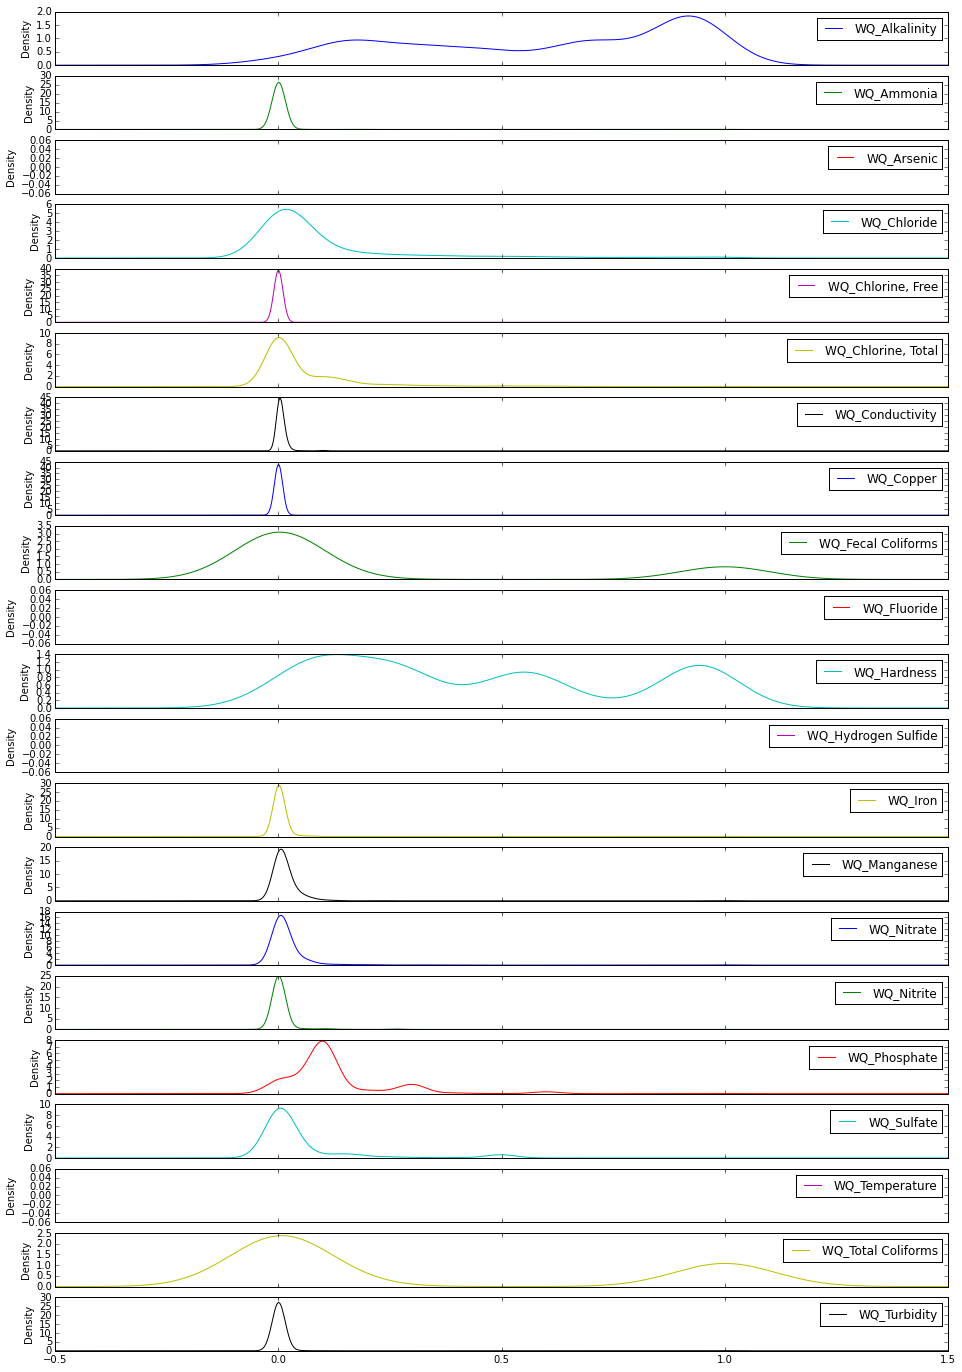

In [7]:
wq_cols = [c for c in d if c.startswith('WQ')]
wq_no_log = [
    'WQ_Alkalinity', 'WQ_Fecal Coliforms', 'WQ_Hardness', 
    'WQ_Temperature', 'WQ_Total Coliforms'
]
wq_log = np.setdiff1d(wq_cols, wq_no_log)
d_plt = d.copy()

#d_plt[wq_log] = d_plt[wq_log].applymap(lambda x: None if pd.isnull(x) else np.log10(x + .01))
d_plt[wq_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))\
    .plot(kind='kde', figsize=(16,24), subplots=True)

In [2]:
# Get current water quality measurements (w/ log transforms)
d, idx_proj, idx_qual = data.get_project_view_04(add_log_transforms=True)

Loading table "AssessmentSummaryInformation"
Loading table "Countries"
Loading table "ProjectsInformation"
Loading table "SafeWaterProjectMonthlySummary"
Loading table "WaterQualityTests"
Loading table "WaterQualityTestParameters"
Loading table "DistributionPoints"


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10fff8f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x113086cf8>], dtype=object)

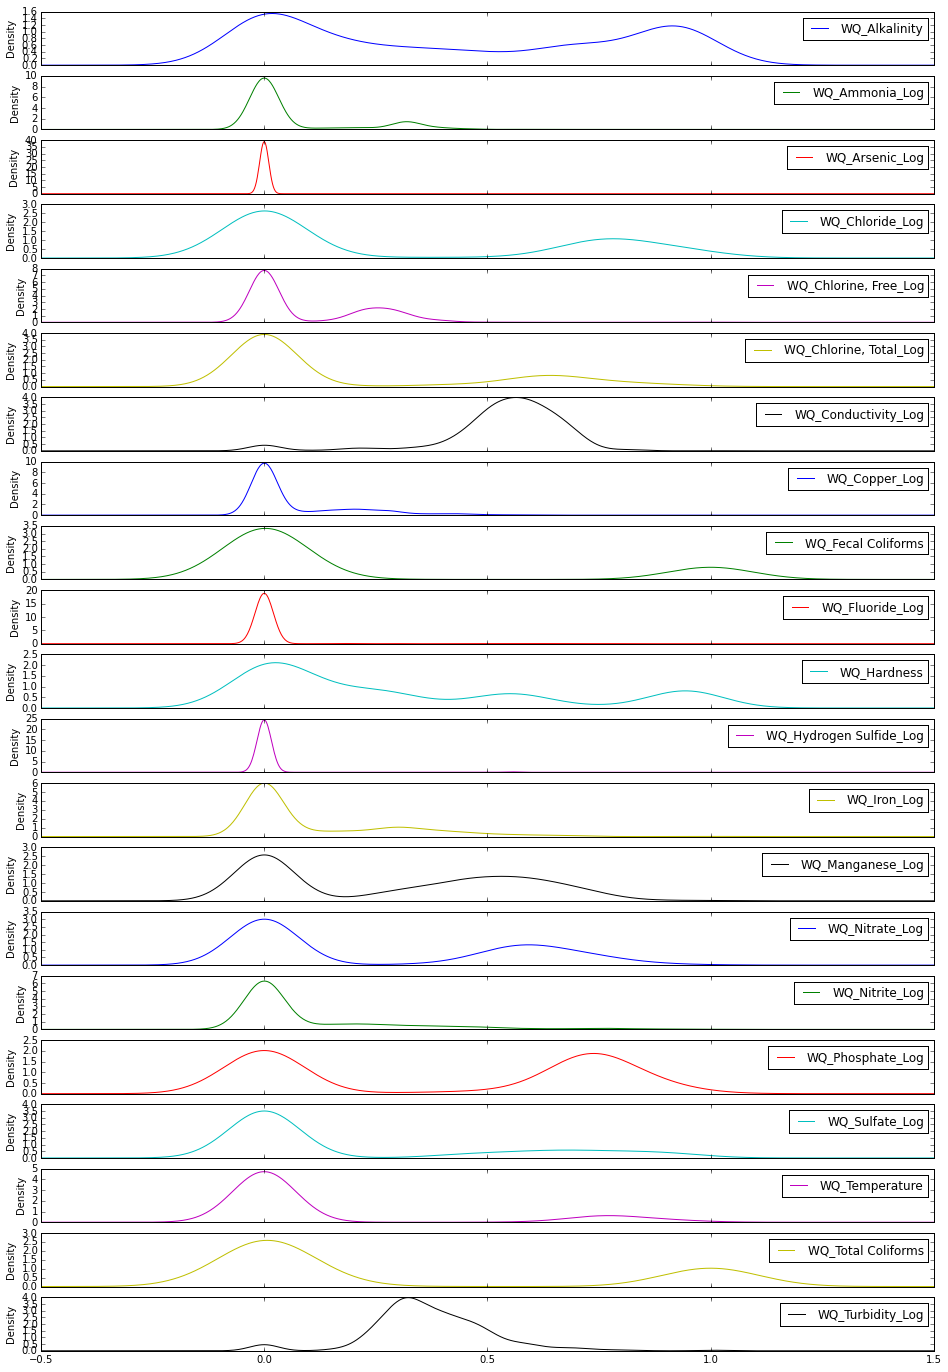

In [10]:
wq_cols = [c for c in d if c.startswith('WQ')]
d[wq_cols].applymap(lambda x: np.nan if not np.isfinite(x) else x)\
    .apply(lambda x: (x - x.min()) / (x.max() - x.min()))\
    .fillna(0).plot(kind='kde', figsize=(16,24), subplots=True)

## Distributions by Group

In [11]:
d_plt = d.reset_index()

In [12]:
wq_cols = [c for c in d_plt if c.startswith('WQ') and c.endswith('Log')]
data = []
for col in wq_cols:
    data.append(go.Box(y=d_plt[col].dropna(), name=col, showlegend=False))
cf.iplot(data)

In [15]:
metric = 'WQ_Nitrate_Log'
data = []
import math
for k, g in d_plt.groupby('Country'):
    v = g[metric].dropna()
    data.append(go.Box(y=v, name=k, showlegend=False))
cf.iplot(data)

In [27]:
pd.isnull(np.inf)

False

In [ ]:
np.isfinite

# Maps

In [3]:
import imp
imp.reload(data)

<module 'research.wmi.data' from '/Users/eczech/repos/portfolio/functional/ml/python/research/wmi/data.py'>

In [4]:
dt = data.load_table('AssessmentSummaryInformation')
dt.info()

Loading table "AssessmentSummaryInformation"
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4116 entries, 0 to 4115
Data columns (total 23 columns):
AssessmentID                      4116 non-null object
AssessmentName                    4084 non-null object
GPSLatitude                       3136 non-null object
GPSLongitude                      3135 non-null object
Population                        2182 non-null object
AnticipatedPeopleServed           2203 non-null object
Budget                            1244 non-null object
FundingNotes                      2448 non-null object
AssessmentNotes                   1758 non-null object
Feasible                          2431 non-null object
ProjectManager                    4111 non-null object
Country                           4030 non-null object
Priority                          4115 non-null object
AssessmentCompletedOn             1907 non-null object
FindFunding                       527 non-null object
NotifyOnUpdateEmails    

In [5]:
param_normalize = lambda d: d.assign(Parameter=d['Parameter'].str.title())

d = pd.merge(
    data.load_table('WaterQualityTests').drop(['GPSLatitude', 'GPSLongitude'], axis=1),
    data.load_table('WaterQualityTestParameters').pipe(param_normalize),
    how='left', on='TestID'
)
d = pd.merge(
    d, 
    data.load_table('AssessmentSummaryInformation')[['AssessmentID', 'Country', 'Region', 'AssessmentName']],
    how='left', on='AssessmentID'
)
d = pd.merge(
    d, 
    data.load_table('WaterQualityStandards').rename(columns={'Units': 'StandardUnits'}).pipe(param_normalize),
    how='left', on='Parameter'
)
d = pd.merge(
    d,
    data.load_table('DistributionPoints'),
    how='left', on=['DistributionPointID', 'AssessmentID']
)

d = d[d['Units'].notnull()]
d = d[d['Value'].notnull()]
d = d[~d['AssessmentName'].apply(lambda x: ' test ' in x.lower())]

# Remove measurements with this parameter and unit combination (not sure how to convert them)
#mask = (d['Parameter'] == 'Chlorine, Free') & (d['Units'] == 'CFU/100ml')
mask = d['Units'] == 'CFU/100ml'
d = d[~mask.values]

d = d[[c for c in d if d[c].notnull().sum() > 0]]

# Normalize measurement units
d = d.groupby('Parameter', group_keys=False).apply(data.convert_water_quality_units)

d.info()

Loading table "WaterQualityTests"
Loading table "WaterQualityTestParameters"
Loading table "AssessmentSummaryInformation"
Loading table "WaterQualityStandards"
Loading table "DistributionPoints"
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30101 entries, 4116 to 75668
Data columns (total 30 columns):
TestID                         30101 non-null object
DistributionPointID            30101 non-null object
AssessmentID                   30101 non-null object
SampleName                     30101 non-null object
SampleDateAndTime              30101 non-null object
ApplicableReport               30101 non-null object
LabTechnicianName              30101 non-null object
FollowUpReportDate             15560 non-null object
Parameter                      30101 non-null object
Value                          30101 non-null float64
AnalysisDateAndTime            30101 non-null object
WaterQualityTestParameterID    30101 non-null object
Units                          30101 non-null object
Cou

In [265]:
d[d['StandardUnits'].isnull()]['Parameter'].value_counts()

Hardness       1764
Temperature     247
Name: Parameter, dtype: int64

In [142]:
d.groupby(['Parameter', 'Units', 'StandardUnits']).size()

Parameter         Units             StandardUnits
Alkalinity        mg/L              ppm              1810
Ammonia           mg/L              ppm               943
Arsenic           mg/L              ppm               104
Chloride          mg/L              ppm              1822
Chlorine, Free    mg/L              ppm              2934
Chlorine, Total   mg/L              ppm              2406
Color             Pt-Co units       Pt-Co units        17
Conductivity      uS/cm             æS/cm            2967
Copper            mg/L              ppm              1809
Fluoride          mg/L              ppm               150
Hydrogen Sulfide  mg/L              ppm               256
Iron              mg/L              ppm              1826
Manganese         mg/L              ppm              1900
Nitrate           mg/L              ppm              1940
Nitrite           mg/L              ppm              1789
Ph                Nov 7 2014 16:00  pH units            3
Phosphate         mg/L

In [268]:
d[['Parameter', 'StandardUnits', 'WHO', 'MBS', 'KBS', 'WMI', 'UNBS']]\
    .set_index(['StandardUnits', 'Parameter']).drop_duplicates().sort_index()

WHO      MBS      KBS       WMI      UNBS
StandardUnits Parameter                                                      
NaN           Hardness              NaN      NaN      NaN       NaN       NaN
NTU           Turbidity           5.000     None     None     5.000     5.000
ppm           Ammonia              None    1.000     None      None      .500
              Arsenic              .050     .050     .010      None      .010
              Chloride          300.000  200.000  250.000   250.000   250.000
              Chlorine, Free      5.000     None     None     4.000      None
              Chlorine, Total      None     None     None     4.000      None
              Copper              2.000    1.000    1.000     1.000      None
              Fluoride            1.500    1.000    1.500      None     1.000
              Hydrogen Sulfide     .100     None     None    10.000      None
              Iron                 .300     .200     .300      .300      .200
              Manganese            .400     .100     .500      .050     1.000
              Nitrate            50.000   10.000   50.000    10.000      None
              Nitrite             3.000     None    3.000     1.000      None
              Phosphate            None     None    2.200    10.000      None
              Sulfate           250.000  400.000  400.000   250.000      None
æS/cm         Conductivity         None     None     None  2000.000  1500.000

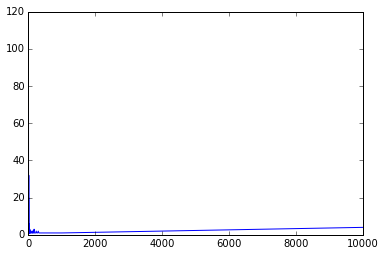

In [269]:
d[d['Parameter'] == 'Turbidity']['Value'].value_counts().sort_index().plot()

In [326]:
from sklearn.preprocessing import MinMaxScaler

#water_params = ['Chloride']
import math
water_params = [
    'Turbidity', 'Chloride', 'Nitrate', 'Nitrite', 
    'Iron', 'Copper', 'Chlorine, Free', 'Chlorine, Total',
    'Copper', 'Manganese'
]
no_log_water_params = ['Alkalinity', 'Fecal Coliforms', 'Hardness', 'Temperature', 'Total Coliforms']

def fix_coords(r):
    lat = r['Lat']
    lon = r['Lon']
    cty = r['Country']
    res = (lat, lon)
    if cty == 'Peru':
      res = (-abs(lat), -abs(lon))
    elif cty == 'Haiti':
      res = (abs(lat), -abs(lon))
    elif cty == 'Indonesia':
      res = (lat, abs(lon))
    elif cty in ['Mexico', 'Honduras']:
      res = (lat, -abs(lon))
    elif cty == 'Liberia':
      res = (abs(lat), lon)
    elif cty == 'Malawi':
      res = (-abs(lat), abs(lon))
    elif cty in ['Tanzania', 'Uganda', 'Kenya']:
      res = (lat, abs(lon))
    return pd.Series(res, index=['Lat', 'Lon'])

def filter_value(r):
    v = r['Value']
    v_log = v
    if r['Parameter'] not in no_log_water_params:
        v_log = math.asinh(v)
        
    v_max = r['WHO']
    if pd.isnull(v_max):
        return pd.Series({'FilteredValue': v_log, 'OverMax': None })
    over_max = v >= float(v_max)
    
    return pd.Series({'FilteredValue': v_log, 'OverMax': over_max })

dmap = d.rename(columns={'GPSLatitude': 'Lat', 'GPSLongitude': 'Lon', 'AnalysisDateAndTime': 'Date'})
dmap['Lon'] = pd.to_numeric(dmap['Lon'], errors='coerce')
dmap['Lat'] = pd.to_numeric(dmap['Lat'], errors='coerce')
dmap['Date'] = pd.to_datetime(dmap['Date'])
dmap = dmap[dmap['Date'].notnull()]
dmap['Parameter'] = dmap['Parameter'].str.title()

dmap = dmap[dmap['Parameter'].isin(water_params)]

dmap = dmap.groupby(['DistributionPointID', 'Parameter'], group_keys=False)\
    .apply(lambda g: g.sort_values('Date').tail(1))

dmap[['Lat', 'Lon']] = dmap.apply(fix_coords, axis=1)

dmap[['FilteredValue', 'OverMax']] = dmap.apply(filter_value, axis=1)

mm = MinMaxScaler()
dmap = dmap.groupby('Parameter', group_keys=False)\
    .apply(lambda g: g.assign(FilteredValue=mm.fit_transform(g['FilteredValue'])))

dmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8539 entries, 50668 to 66952
Data columns (total 32 columns):
TestID                         8539 non-null object
DistributionPointID            8539 non-null object
AssessmentID                   8539 non-null object
SampleName                     8539 non-null object
SampleDateAndTime              8539 non-null object
ApplicableReport               8539 non-null object
LabTechnicianName              8539 non-null object
FollowUpReportDate             2101 non-null object
Parameter                      8539 non-null object
Value                          8539 non-null float64
Date                           8539 non-null datetime64[ns]
WaterQualityTestParameterID    8539 non-null object
Units                          8539 non-null object
Country                        8539 non-null object
Region                         8165 non-null object
AssessmentName                 8539 non-null object
WaterQualityStandardID         8539 non-null ob

## Geo Exports

In [327]:
dmap[(dmap['Lat'].abs() > 0) & (dmap['Lon'].abs() > 0)]\
    .to_csv('/Users/eczech/data/research/wmi/data/exports/wmi_water_quality_geo.csv', index=False)

## Plotly Maps

In [281]:
dmap['Country'].value_counts()

Haiti          128
Malawi         112
Uganda          87
Kenya           78
Tanzania        75
Liberia         73
Indonesia       71
Mexico          60
Nepal           60
Honduras        50
Peru            29
Philippines     11
Cambodia         6
Somalia          2
Guatemala        1
Name: Country, dtype: int64

In [287]:
dmap[dmap['Parameter'] == 'Turbidity']['OverMax'].value_counts()

False    891
True     252
Name: OverMax, dtype: int64

In [288]:
import math
import plotly.graph_objs as go
traces = []

ctys = dmap['Country'].value_counts().sort_values().tail(13).index.values

def scale(g):
    param = g['Parameter'].iloc[0]
    v = g['FilteredValue']
    
    # if param in ['Nitrate']:
        # v = v.apply(math.asinh)

    v = 5 + 30 * (v - v.min()) / (v.max() - v.min())
    g['Size'] = np.where(g['OverMax'], 30, v)
    return g

def get_text(r):
    return '{}<br>{}<br>{}'.format(r['AssessmentName'], r['DistributionPointName'], r['Region'])

def get_symbol(r):
    return 'x' if r['OverMax'] else 'circle'

dgeo = dmap[dmap['Country'].isin(ctys)]
dgeo = dgeo.groupby('Parameter', group_keys=False).apply(scale)
dgeo['Text'] = dgeo.apply(get_text, axis=1)
dgeo['Symbol'] = dgeo.apply(get_symbol, axis=1)

symbol_map = {'Nitrate': 'circle', 'Turbidity': 'circle'}

for k, g in dgeo.groupby(['Country', 'Parameter']):
    cty, param = k
    traces.append(
        dict(
            type = 'scattergeo',
            lon = g['Lon'],
            lat = g['Lat'],
            text = g['Text'],
            mode = 'markers',
            name=cty,
            #legendgroup=param,
            marker = dict(
                size = g['Size'],
                symbol= g['Symbol'],
                line = dict(width=0.5, color='rgb(40,40,40)'),
                sizemode = 'area'
            )
        )
    )

layout = dict(
    geo = dict(
        projection=dict(type='natural earth'),
        showland=True,
        landcolor='C7DFC4',
        showcountries=True,
        showsubunits=True,
        subunitcolor='black',
        subunitwidth=1,
        countrywidth=1,
        countrycolor='black',
        showocean=True,
        oceancolor='EBF8FF',
        showrivers=True,
        rivercolor='DCF1FF'
    ),
    autosize=False,
    width=800,
    height=800,
)
fig = dict(data=traces, layout=layout)
cf.iplot(fig)
        